<font size=18>Cluster analyses of the image embeddings</font>

---

In this notebook we analyze the computed image embeddings from the large-scale screen of the JUMP data set. We will also assess the agreement of the clustering with the results of our analyses using the data set by Rohban et al. (2017).

---

# Environmental setup

In [1]:
import pandas as pd
import numpy as np
from venn import venn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from cmapPy.pandasGEXpress.parse import parse
from scipy.spatial.distance import squareform, pdist
import matplotlib as mpl
import pickle

import sys
from yellowbrick.cluster import KElbowVisualizer

sys.path.append("../../../..")
from src.utils.notebooks.ppi.embedding import plot_tsne_embs
from src.utils.notebooks.images.embedding import *
from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *

mpl.rcParams["figure.dpi"] = 600

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def run_cc_test(cluster_sol1, cluster_sol2, b=1000, score="mi", random_state=1234):
    np.random.seed(random_state)
    cc_score = compute_cc_score(cluster_sol1, cluster_sol2, score=score)
    perm_cc_scores = []
    for i in tqdm(range(b)):
        cluster_sol1_perm = np.random.permutation(cluster_sol1)
        cluster_sol2_perm = np.random.permutation(cluster_sol2)
        perm_cc_score = compute_cc_score(
            cluster_sol1_perm, cluster_sol2_perm, score=score
        )
        perm_cc_scores.append(perm_cc_score)
    perm_cc_scores = np.array(perm_cc_scores)
    return {
        "cc_score": cc_score,
        "perm_cc_scores": perm_cc_scores,
        "pval": np.mean(perm_cc_scores >= (cc_score - 1e-8), axis=0),
    }


<IPython.core.display.Javascript object>

---

# Read in data

We will now read in the required data sets.

## JUMP embeddings

First, of all these are the image embeddings obtained for all perturbation conditions that are covered in our previously identified GGI. Note that to this end, first obtain the embeddings for all considered perturbation settings that include the 32 perturbation conditions used to train the encoder model and additional 144. Embeddings are obtained for all samples of all of these conditions (partially including those used for training) using the trained encoder model.

In [3]:
jump_train_embs = pd.read_hdf(
    "../../../../data/experiments/image_embeddings/jump/specificity_target_emb_cv_strat/fold_0/jump_latents_nuclei_region/train_latents.h5"
)
jump_val_embs = pd.read_hdf(
    "../../../../data/experiments/image_embeddings/jump/specificity_target_emb_cv_strat/fold_0/jump_latents_nuclei_region/val_latents.h5"
)
jump_test_embs = pd.read_hdf(
    "../../../../data/experiments/image_embeddings/jump/specificity_target_emb_cv_strat/fold_0/jump_latents_nuclei_region/test_latents.h5"
)

jump_embs = pd.concat([jump_train_embs, jump_val_embs, jump_test_embs])

<IPython.core.display.Javascript object>

In [4]:
label_dict = {
    "AKT1S1": 0,
    "ATF4": 1,
    "BAX": 2,
    "BCL2L11": 3,
    "BRAF": 4,
    "CASP8": 5,
    "CDKN1A": 6,
    "CREB1": 7,
    "DIABLO": 8,
    "ELK1": 9,
    "EMPTY": 10,
    "ERG": 11,
    "FGFR3": 12,
    "HRAS": 13,
    "IRAK4": 14,
    "JUN": 15,
    "MAP3K2": 16,
    "MAP3K5": 17,
    "MAP3K9": 18,
    "MYD88": 19,
    "PIK3R2": 20,
    "PRKACA": 21,
    "PRKCE": 22,
    "RAF1": 23,
    "RELB": 24,
    "RHOA": 25,
    "SMAD4": 26,
    "SRC": 27,
    "SREBF1": 28,
    "TRAF2": 29,
    "TSC2": 30,
    "WWTR1": 31,
    "ALOX5": 32,
    "AMPH": 33,
    "AQP1": 34,
    "ARMCX2": 35,
    "AURKA": 36,
    "AURKB": 37,
    "AXL": 38,
    "BEX1": 39,
    "BIRC5": 40,
    "BMP4": 41,
    "BUB1": 42,
    "BUB1B": 43,
    "CCNA2": 44,
    "CCND2": 45,
    "CD40": 46,
    "CDC20": 47,
    "CDC42EP1": 48,
    "CDC45": 49,
    "CDCA3": 50,
    "CDCA8": 51,
    "CDK1": 52,
    "CDK14": 53,
    "CDK2": 54,
    "CDK6": 55,
    "CENPA": 56,
    "CKS2": 57,
    "CLSPN": 58,
    "CLU": 59,
    "CNN1": 60,
    "CRYAB": 61,
    "CYBA": 62,
    "DHRS2": 63,
    "DUSP6": 64,
    "EEF1A2": 65,
    "EFEMP1": 66,
    "EPB41L3": 67,
    "EXO1": 68,
    "FEN1": 69,
    "FGF1": 70,
    "FGFR2": 71,
    "FKBP4": 72,
    "FOS": 73,
    "FOXM1": 74,
    "FSTL1": 75,
    "GTSE1": 76,
    "HJURP": 77,
    "HK2": 78,
    "HSP90AB1": 79,
    "HSPA1B": 80,
    "IGF2": 81,
    "IGFBP5": 82,
    "INHBA": 83,
    "KIF2C": 84,
    "KLK6": 85,
    "KPNA2": 86,
    "KRT15": 87,
    "KRT18": 88,
    "KRT8": 89,
    "KRT80": 90,
    "KRT81": 91,
    "LBH": 92,
    "LDOC1": 93,
    "LGALS1": 94,
    "LOXL4": 95,
    "LRP1": 96,
    "LTBP2": 97,
    "LZTS2": 98,
    "MAGEA1": 99,
    "MAGEA4": 100,
    "MAGED1": 101,
    "MAPK8": 102,
    "MBP": 103,
    "MCM10": 104,
    "MCM3": 105,
    "MCM5": 106,
    "MCM7": 107,
    "MDFI": 108,
    "MDK": 109,
    "MSH2": 110,
    "MYH9": 111,
    "MYL2": 112,
    "NCF2": 113,
    "NDC80": 114,
    "NDN": 115,
    "NEFL": 116,
    "NEK2": 117,
    "NUF2": 118,
    "PAK2": 119,
    "PCLO": 120,
    "PCNA": 121,
    "PDGFRB": 122,
    "PLAT": 123,
    "PLK1": 124,
    "PRAME": 125,
    "PRC1": 126,
    "PRKCA": 127,
    "PRSS23": 128,
    "PTCH1": 129,
    "RACGAP1": 130,
    "RARA": 131,
    "RPS6KB1": 132,
    "RRM2": 133,
    "S100A14": 134,
    "SDC1": 135,
    "SDC2": 136,
    "SDC3": 137,
    "SERPINE1": 138,
    "SFN": 139,
    "SKP2": 140,
    "SPARC": 141,
    "SPC24": 142,
    "SPC25": 143,
    "STAC": 144,
    "STC2": 145,
    "SUV39H1": 146,
    "TCF4": 147,
    "TGFB1": 148,
    "TGM2": 149,
    "THRA": 150,
    "THY1": 151,
    "TIMP1": 152,
    "TINAGL1": 153,
    "TK1": 154,
    "TNC": 155,
    "TNNC1": 156,
    "TNNT1": 157,
    "TNNT2": 158,
    "TONSL": 159,
    "TPM1": 160,
    "TPM2": 161,
    "TPX2": 162,
    "TRIB3": 163,
    "TTK": 164,
    "TUBA1A": 165,
    "TUBB": 166,
    "TUBB2B": 167,
    "TUBB6": 168,
    "UBE2S": 169,
    "UCHL5": 170,
    "VCAN": 171,
    "VIM": 172,
    "YES1": 173,
    "YWHAQ": 174,
    "ZWINT": 175,
}

label_dict = dict(zip(list(label_dict.values()), list(label_dict.keys())))
jump_embs.loc[:, "labels"] = np.array(jump_embs.labels.map(label_dict))
mean_jump_embs = jump_embs.groupby("labels").mean()
oe_targets = set(mean_jump_embs.index) - {"EMPTY"}

<IPython.core.display.Javascript object>

In [5]:
with open("../../../../data/other/target_lists/jump_targets.pkl", "wb") as handle:
    pickle.dump(oe_targets, handle, protocol=pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>

As for the analyses using the dataset by Rohban et al. we obtain a perturbation embedding for each gene targeted for overexpression by computing the mean of the image embeddings. Thus, we obtain 175 gene perturbation embeddings and one control perturbation embedding.

In [6]:
mean_jump_embs.describe()

zs_0        zs_1        zs_2        zs_3        zs_4        zs_5  \
count  176.000000  176.000000  176.000000  176.000000  176.000000  176.000000   
mean    -0.026828   -0.215102    0.069726    0.189563   -0.362678    0.019130   
std      0.113527    0.062572    0.074553    0.088185    0.104262    0.114715   
min     -0.238921   -0.375479   -0.103423   -0.014611   -0.574803   -0.278140   
25%     -0.123286   -0.253456    0.021183    0.114717   -0.434169   -0.055441   
50%     -0.030288   -0.213978    0.073318    0.197104   -0.387922    0.012776   
75%      0.048576   -0.183421    0.111420    0.248850   -0.310470    0.068234   
max      0.371939    0.000766    0.287380    0.419424   -0.106901    0.282348   

             zs_6        zs_7        zs_8        zs_9  ...     zs_1014  \
count  176.000000  176.000000  176.000000  176.000000  ...  176.000000   
mean    -0.021513    0.228243    0.039979   -0.087771  ...    0.193101   
std      0.088146    0.084853    0.072512    0.126424  ...    0.100320   
min     -0.264454    0.098953   -0.125114   -0.302061  ...    0.022858   
25%     -0.073878    0.173330   -0.020437   -0.184989  ...    0.110884   
50%     -0.002395    0.198229    0.043880   -0.117696  ...    0.166947   
75%      0.035705    0.256996    0.096130   -0.026016  ...    0.272484   
max      0.156877    0.479077    0.219938    0.302316  ...    0.436841   

          zs_1015     zs_1016     zs_1017     zs_1018     zs_1019     zs_1020  \
count  176.000000  176.000000  176.000000  176.000000  176.000000  176.000000   
mean     0.043680   -0.139272   -0.008726   -0.032865    0.103365   -0.245643   
std      0.087820    0.052769    0.097877    0.072367    0.064609    0.057641   
min     -0.160894   -0.317363   -0.291164   -0.194426   -0.075853   -0.394518   
25%     -0.040373   -0.164396   -0.079780   -0.077848    0.052145   -0.284007   
50%      0.054550   -0.142942   -0.015124   -0.036718    0.108134   -0.241147   
75%      0.120206   -0.118899    0.050170    0.008550    0.154543   -0.205166   
max      0.246182    0.105679    0.224094    0.163896    0.343935   -0.089244   

          zs_1021     zs_1022     zs_1023  
count  176.000000  176.000000  176.000000  
mean     0.081539   -0.019244   -0.099954  
std      0.099882    0.140664    0.066571  
min     -0.166866   -0.314632   -0.265490  
25%      0.000154   -0.134293   -0.160879  
50%      0.084371   -0.018291   -0.099704  
75%      0.160342    0.084475   -0.049773  
max      0.304638    0.344653    0.060910  

[8 rows x 1024 columns]

<IPython.core.display.Javascript object>

---

## Rohban embeddings

Since, we want to compare the clustering structure of the embeddings obtained for the JUMP to the one from the Rohban data set, we also read in the corresponding embeddings.

In [7]:
rohban_embs = pd.read_hdf(
    "../../../../data/experiments/image_embeddings/rohban/specificity_target_emb_cv_strat/final_1024/fold_0/test_latents.h5"
)

label_dict = {
    "AKT1S1": 0,
    "ATF4": 1,
    "BAX": 2,
    "BCL2L11": 3,
    "BRAF": 4,
    "CASP8": 5,
    "CDC42": 6,
    "CDKN1A": 7,
    "CEBPA": 8,
    "CREB1": 9,
    "CXXC4": 10,
    "DIABLO": 11,
    "E2F1": 12,
    "ELK1": 13,
    "EMPTY": 14,
    "ERG": 15,
    "FGFR3": 16,
    "FOXO1": 17,
    "GLI1": 18,
    "HRAS": 19,
    "IRAK4": 20,
    "JUN": 21,
    "MAP2K3": 22,
    "MAP3K2": 23,
    "MAP3K5": 24,
    "MAP3K9": 25,
    "MAPK7": 26,
    "MOS": 27,
    "MYD88": 28,
    "PIK3R2": 29,
    "PRKACA": 30,
    "PRKCE": 31,
    "RAF1": 32,
    "RELB": 33,
    "RHOA": 34,
    "SMAD4": 35,
    "SMO": 36,
    "SRC": 37,
    "SREBF1": 38,
    "TRAF2": 39,
    "TSC2": 40,
    "WWTR1": 41,
}
label_dict = dict(zip(list(label_dict.values()), list(label_dict.keys())))
rohban_embs.loc[:, "labels"] = np.array(rohban_embs.labels.map(label_dict))
mean_rohban_embs = rohban_embs.groupby("labels").mean()
mean_rohban_embs.describe()

zs_0       zs_1       zs_2       zs_3       zs_4       zs_5  \
count  42.000000  42.000000  42.000000  42.000000  42.000000  42.000000   
mean    0.139138  -0.203870   0.241791   0.273090  -0.168133   0.159023   
std     0.110992   0.066884   0.112188   0.067496   0.069304   0.073108   
min    -0.021475  -0.361162   0.026488   0.169555  -0.357724   0.046746   
25%     0.062262  -0.243624   0.177016   0.221073  -0.206028   0.109388   
50%     0.124145  -0.210707   0.221518   0.253942  -0.167655   0.150231   
75%     0.191867  -0.148665   0.277807   0.338618  -0.125459   0.191480   
max     0.446245  -0.083567   0.552403   0.406600   0.002958   0.362232   

            zs_6       zs_7       zs_8       zs_9  ...    zs_1014    zs_1015  \
count  42.000000  42.000000  42.000000  42.000000  ...  42.000000  42.000000   
mean    0.178019   0.324089   0.187835   0.032706  ...   0.012636  -0.021156   
std     0.066482   0.074958   0.103115   0.088327  ...   0.068049   0.052975   
min     0.085924   0.174395   0.039302  -0.215125  ...  -0.120953  -0.102587   
25%     0.139284   0.269405   0.095040   0.002869  ...  -0.020316  -0.074753   
50%     0.166074   0.311268   0.182711   0.030569  ...   0.011648  -0.013830   
75%     0.197378   0.386146   0.249037   0.087261  ...   0.039714   0.010913   
max     0.386828   0.456463   0.428905   0.229852  ...   0.157981   0.089266   

         zs_1016    zs_1017    zs_1018    zs_1019    zs_1020    zs_1021  \
count  42.000000  42.000000  42.000000  42.000000  42.000000  42.000000   
mean    0.366756  -0.121617  -0.091095  -0.016842  -0.179879  -0.112260   
std     0.086552   0.065176   0.069599   0.059016   0.055876   0.061663   
min     0.188729  -0.301541  -0.282774  -0.195051  -0.327569  -0.252322   
25%     0.296616  -0.152134  -0.122182  -0.053789  -0.210487  -0.151609   
50%     0.363362  -0.111600  -0.078834  -0.025155  -0.186020  -0.109610   
75%     0.427962  -0.094031  -0.044472   0.019535  -0.154469  -0.083475   
max     0.547274   0.025293   0.048329   0.125359  -0.045234   0.026040   

         zs_1022    zs_1023  
count  42.000000  42.000000  
mean    0.370572  -0.024516  
std     0.096443   0.088365  
min     0.201598  -0.228888  
25%     0.305496  -0.076441  
50%     0.354419  -0.042233  
75%     0.417904   0.026988  
max     0.600048   0.191578  

[8 rows x 1024 columns]

<IPython.core.display.Javascript object>

---

## CMAP signatures

We next load the preprocessed CMAP data set.

In [8]:
mean_cmap_sigs = pd.read_csv(
    "../../../../data/gex/cmap/mean_l5_signatures_tmp.csv", index_col=0
)
mean_cmap_sigs.describe()

RFX5         EED    EIF4EBP1        COG4       FGFR2       ERBB3  \
count  188.000000  188.000000  188.000000  188.000000  188.000000  188.000000   
mean    -0.582265   -0.016228   -0.161962   -0.125646    0.170201    0.037915   
std      1.329533    0.808633    0.738878    0.924764    0.664445    0.801662   
min     -6.353000   -2.817000   -3.106975   -4.455450   -1.551750   -2.126400   
25%     -1.197350   -0.462385   -0.555113   -0.663106   -0.271125   -0.466763   
50%     -0.326037    0.015700   -0.128225    0.035275    0.133325   -0.069850   
75%      0.271156    0.514644    0.260756    0.478975    0.521775    0.435887   
max      2.217800    3.305350    2.429900    1.979600    2.868650    3.578800   

            ZMIZ1        NCK1       BLCAP        RPA3  ...       PTPRC  \
count  188.000000  188.000000  188.000000  188.000000  ...  188.000000   
mean     0.171940    0.404997    0.257612   -0.454373  ...    0.224485   
std      0.926505    0.790740    0.979683    1.021058  ...    0.755197   
min     -2.553650   -1.787900   -2.244100   -4.774300  ...   -1.508900   
25%     -0.438147   -0.155081   -0.343856   -0.897028  ...   -0.273922   
50%      0.091050    0.369437    0.100738   -0.326275  ...    0.143550   
75%      0.660725    0.799425    0.654879    0.269356  ...    0.516428   
max      4.863400    3.041100    3.689400    1.261650  ...    3.277975   

           ZNF131       NOSIP      ZNF274         LBR       CEBPA      PIK3R4  \
count  188.000000  188.000000  188.000000  188.000000  188.000000  188.000000   
mean     0.292028   -0.570563    0.451111   -0.233995    0.099003   -0.223659   
std      0.893929    1.521973    1.248834    0.999578    1.049661    0.679024   
min     -2.612900   -9.152000   -2.063050   -4.110900   -1.807925   -2.019500   
25%     -0.330656   -1.051063   -0.307219   -0.576813   -0.408175   -0.636550   
50%      0.261392   -0.113308    0.161288   -0.054058   -0.017650   -0.212162   
75%      0.914075    0.385569    0.904338    0.393058    0.421156    0.188494   
max      3.196800    1.594950    9.013600    1.476800   10.000000    2.287350   

             POLB        CAST       CASP7  
count  188.000000  188.000000  188.000000  
mean    -0.235256    0.049812   -0.007515  
std      0.939153    1.080501    0.759344  
min     -3.338000  -10.000000   -2.323775  
25%     -0.778669   -0.300303   -0.489262  
50%     -0.196269    0.101900   -0.035721  
75%      0.379769    0.562519    0.464894  
max      2.615900    1.925825    2.376750  

[8 rows x 978 columns]

<IPython.core.display.Javascript object>

---

## Morphological profiles

Finally, we load the computed morphological profiles used by Rohban et al. to characterize the OE condition covered in their study.

In [9]:
morph_profiles = pd.read_csv(
    "../../../../data/images/rohban/metadata/nuclei_profiles_hoechst_cleaned.csv",
    index_col=0,
)
mean_morph_profiles = (
    morph_profiles.groupby("labels").mean().drop(columns=["ImageNumber"])
)

<IPython.core.display.Javascript object>

Similarly as in our previous analyses, we remove any features from the morphological profiles related to the location of the cells and normalize the data set.

In [10]:
mean_morph_profiles = mean_morph_profiles.drop(
    mean_morph_profiles.filter(regex="_X").columns, axis=1
)
mean_morph_profiles = mean_morph_profiles.drop(
    mean_morph_profiles.filter(regex="_Y").columns, axis=1
)
mean_morph_profiles = pd.DataFrame(
    StandardScaler().fit_transform(mean_morph_profiles),
    index=mean_morph_profiles.index,
    columns=mean_morph_profiles.columns,
)
mean_morph_profiles.describe()

Nuclei_AreaShape_Area  Nuclei_AreaShape_Compactness  \
count           1.940000e+02                  1.940000e+02   
mean            2.746944e-16                  3.497775e-15   
std             1.002587e+00                  1.002587e+00   
min            -4.831180e+00                 -4.124415e+00   
25%            -2.967397e-01                 -3.573091e-01   
50%             4.226735e-02                  5.350382e-02   
75%             3.795699e-01                  5.570907e-01   
max             4.507893e+00                  2.616509e+00   

       Nuclei_AreaShape_Eccentricity  Nuclei_AreaShape_EulerNumber  \
count                   1.940000e+02                  1.940000e+02   
mean                    9.712735e-15                  4.609829e-14   
std                     1.002587e+00                  1.002587e+00   
min                    -4.160595e+00                 -6.328147e+00   
25%                    -2.343684e-01                 -3.641613e-01   
50%                     1.988131e-01                  1.293421e-01   
75%                     5.091096e-01                  5.554614e-01   
max                     2.126083e+00                  1.395599e+00   

       Nuclei_AreaShape_Extent  Nuclei_AreaShape_FormFactor  \
count             1.940000e+02                 1.940000e+02   
mean              4.023128e-14                 5.145941e-15   
std               1.002587e+00                 1.002587e+00   
min              -3.412265e+00                -3.061537e+00   
25%              -5.489673e-01                -6.104759e-01   
50%              -4.722521e-02                 4.546483e-02   
75%               5.971932e-01                 5.250496e-01   
max               3.345825e+00                 3.582763e+00   

       Nuclei_AreaShape_MajorAxisLength  Nuclei_AreaShape_MaxFeretDiameter  \
count                      1.940000e+02                       1.940000e+02   
mean                      -9.156479e-16                       1.904548e-15   
std                        1.002587e+00                       1.002587e+00   
min                       -5.506697e+00                      -5.568058e+00   
25%                       -2.048273e-01                      -1.930504e-01   
50%                        1.741708e-01                       1.725935e-01   
75%                        4.135426e-01                       4.228811e-01   
max                        3.339119e+00                       3.343600e+00   

       Nuclei_AreaShape_MaximumRadius  Nuclei_AreaShape_MeanRadius  ...  \
count                    1.940000e+02                 1.940000e+02  ...   
mean                    -3.085733e-15                 2.865978e-15  ...   
std                      1.002587e+00                 1.002587e+00  ...   
min                     -4.229009e+00                -4.578572e+00  ...   
25%                     -3.719525e-01                -3.268387e-01  ...   
50%                     -6.040198e-04                 5.619600e-02  ...   
75%                      4.147226e-01                 3.857357e-01  ...   
max                      4.047542e+00                 4.269307e+00  ...   

       Nuclei_Texture_SumAverage_Hoechst_5_0  \
count                           1.940000e+02   
mean                           -8.916121e-15   
std                             1.002587e+00   
min                            -5.334400e+00   
25%                            -3.641006e-01   
50%                             1.244704e-01   
75%                             6.291652e-01   
max                             1.898634e+00   

       Nuclei_Texture_SumEntropy_Hoechst_10_0  \
count                            1.940000e+02   
mean                             1.690744e-14   
std                              1.002587e+00   
min                             -5.493125e+00   
25%                             -5.928939e-01   
50%                             -8.671585e-02   
75%                              4.540802e-01   
max                              3.883853e+00

<IPython.core.display.Javascript object>

In [11]:
print(list(mean_morph_profiles.columns))

['Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Compactness', 'Nuclei_AreaShape_Eccentricity', 'Nuclei_AreaShape_EulerNumber', 'Nuclei_AreaShape_Extent', 'Nuclei_AreaShape_FormFactor', 'Nuclei_AreaShape_MajorAxisLength', 'Nuclei_AreaShape_MaxFeretDiameter', 'Nuclei_AreaShape_MaximumRadius', 'Nuclei_AreaShape_MeanRadius', 'Nuclei_AreaShape_MedianRadius', 'Nuclei_AreaShape_MinFeretDiameter', 'Nuclei_AreaShape_MinorAxisLength', 'Nuclei_AreaShape_Orientation', 'Nuclei_AreaShape_Perimeter', 'Nuclei_AreaShape_Solidity', 'Nuclei_AreaShape_Zernike_0_0', 'Nuclei_AreaShape_Zernike_1_1', 'Nuclei_AreaShape_Zernike_2_0', 'Nuclei_AreaShape_Zernike_2_2', 'Nuclei_AreaShape_Zernike_3_1', 'Nuclei_AreaShape_Zernike_3_3', 'Nuclei_AreaShape_Zernike_4_0', 'Nuclei_AreaShape_Zernike_4_2', 'Nuclei_AreaShape_Zernike_4_4', 'Nuclei_AreaShape_Zernike_5_1', 'Nuclei_AreaShape_Zernike_5_3', 'Nuclei_AreaShape_Zernike_5_5', 'Nuclei_AreaShape_Zernike_6_0', 'Nuclei_AreaShape_Zernike_6_2', 'Nuclei_AreaShape_Zernike_6_4', 'Nuc

<IPython.core.display.Javascript object>

---

# Clustering of the different signatures and embeddings

We will now assess the clustering and co-clustering of the different overexpression conditions.

In [12]:
shared_genes = (
    set(mean_jump_embs.index)
    .intersection(mean_rohban_embs.index)
    .intersection(mean_morph_profiles.index)
    .intersection(mean_cmap_sigs.index)
)
len(shared_genes)

31

<IPython.core.display.Javascript object>

## Embeddings of shared targets.

First, we will cluster only the genes for which corresponding embeddings are available from the CMAP, the morphological profile, the Rohban imaging and the JUMP imaging data set. In total these are 31 genes.


---

### JUMP embeddings

<ipython-input-13-b35e43be2aea>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_jump_embs.loc[shared_genes])


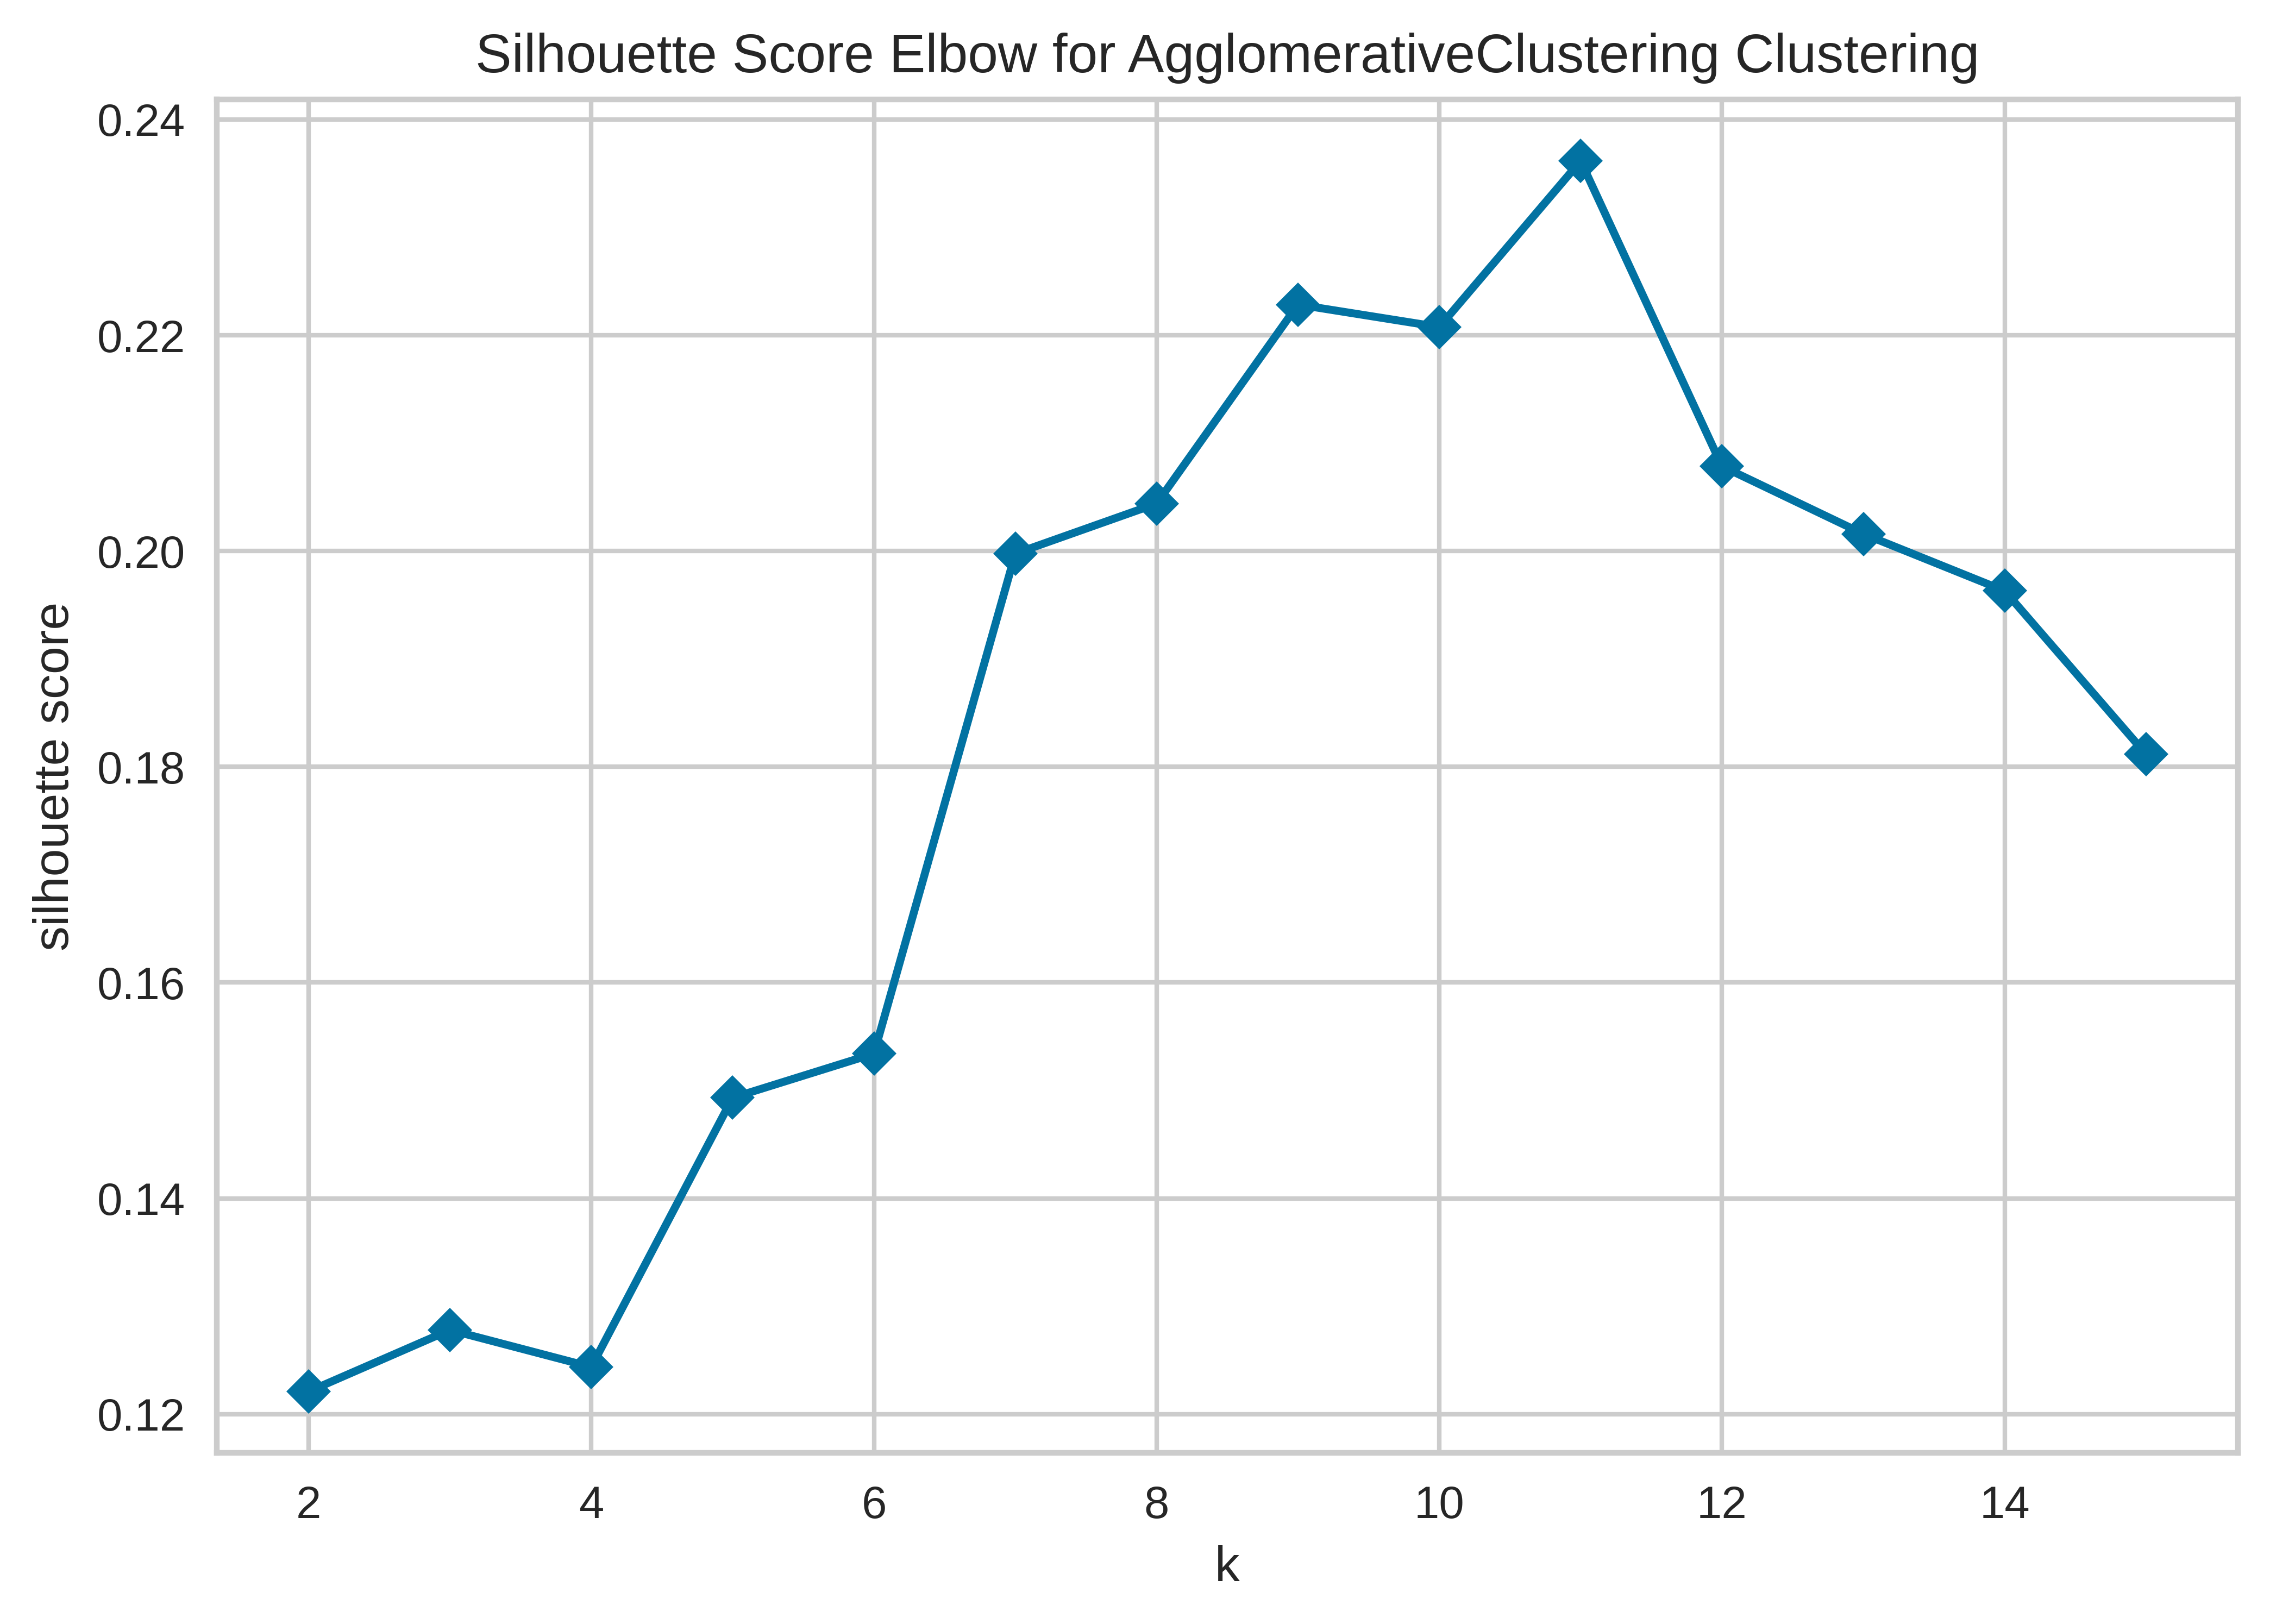

<ipython-input-13-b35e43be2aea>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_jump_embs.loc[shared_genes])


<IPython.core.display.Javascript object>

In [13]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_jump_embs.loc[shared_genes])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_jump_embs.loc[shared_genes])
ax = visualizer.show()


We see that the Silhouette and Calinski-Harabasz score attain local optima at 11 clusters. Thus, we proceed in our analysis by clustering the 31 genes into 11 distinct clusters.

In [14]:
model = AgglomerativeClustering(n_clusters=11, affinity="euclidean", linkage="complete")
shared_jump_cluster_labels = model.fit_predict(mean_jump_embs.loc[shared_genes])
shared_jump_cluster = pd.DataFrame(
    shared_jump_cluster_labels,
    index=mean_jump_embs.loc[shared_genes].index,
    columns=["cluster"],
)
lut = dict(
    zip(
        list(np.unique(shared_jump_cluster)),
        [
            "tab:blue",
            "tab:red",
            "tab:green",
            "gold",
            "tab:orange",
            "tab:cyan",
            "tab:purple",
            "tab:pink",
            "tab:olive",
            "olivedrab",
            "tab:brown",
        ],
    )
)
jump_embs_colors = pd.Series(
    shared_jump_cluster_labels,
    index=mean_jump_embs.loc[shared_genes].index,
).map(lut)

<ipython-input-14-0329539e161f>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  shared_jump_cluster_labels = model.fit_predict(mean_jump_embs.loc[shared_genes])
<ipython-input-14-0329539e161f>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_jump_embs.loc[shared_genes].index,
<ipython-input-14-0329539e161f>:28: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_jump_embs.loc[shared_genes].index,


<IPython.core.display.Javascript object>

In [15]:
mean_shared_jump_embs_dist = pd.DataFrame(
    squareform(pdist(mean_jump_embs.loc[shared_genes])),
    index=mean_jump_embs.loc[shared_genes].index,
    columns=mean_jump_embs.loc[shared_genes].index,
)

linkage = hc.linkage(squareform(mean_shared_jump_embs_dist), method="complete")

ax = sns.clustermap(
    mean_shared_jump_embs_dist,
    figsize=[14, 12],
    row_linkage=linkage,
    col_linkage=linkage,
    cmap="gray",
    row_colors=np.array(jump_embs_colors.loc[mean_shared_jump_embs_dist.index]),
    col_colors=np.array(jump_embs_colors.loc[mean_shared_jump_embs_dist.index]),
    dendrogram_ratio=0.1,
    cbar_pos=(0.04, 0.88, 0.03, 0.1),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
ax.ax_heatmap.set_ylabel("")
ax.ax_heatmap.set_xlabel("")
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()


<ipython-input-15-c57fc5896472>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  squareform(pdist(mean_jump_embs.loc[shared_genes])),
<ipython-input-15-c57fc5896472>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_jump_embs.loc[shared_genes].index,
<ipython-input-15-c57fc5896472>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  columns=mean_jump_embs.loc[shared_genes].index,


<IPython.core.display.Javascript object>

---

### Rohban embeddings

As a first step we will compare the observed cluster structure in the JUMP embeddings to the one of the Rohban embeddings. To this end, we will first identify the optiomal number of clusters for the latter as before.

<ipython-input-16-d4ad6d921b49>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_rohban_embs.loc[shared_genes])


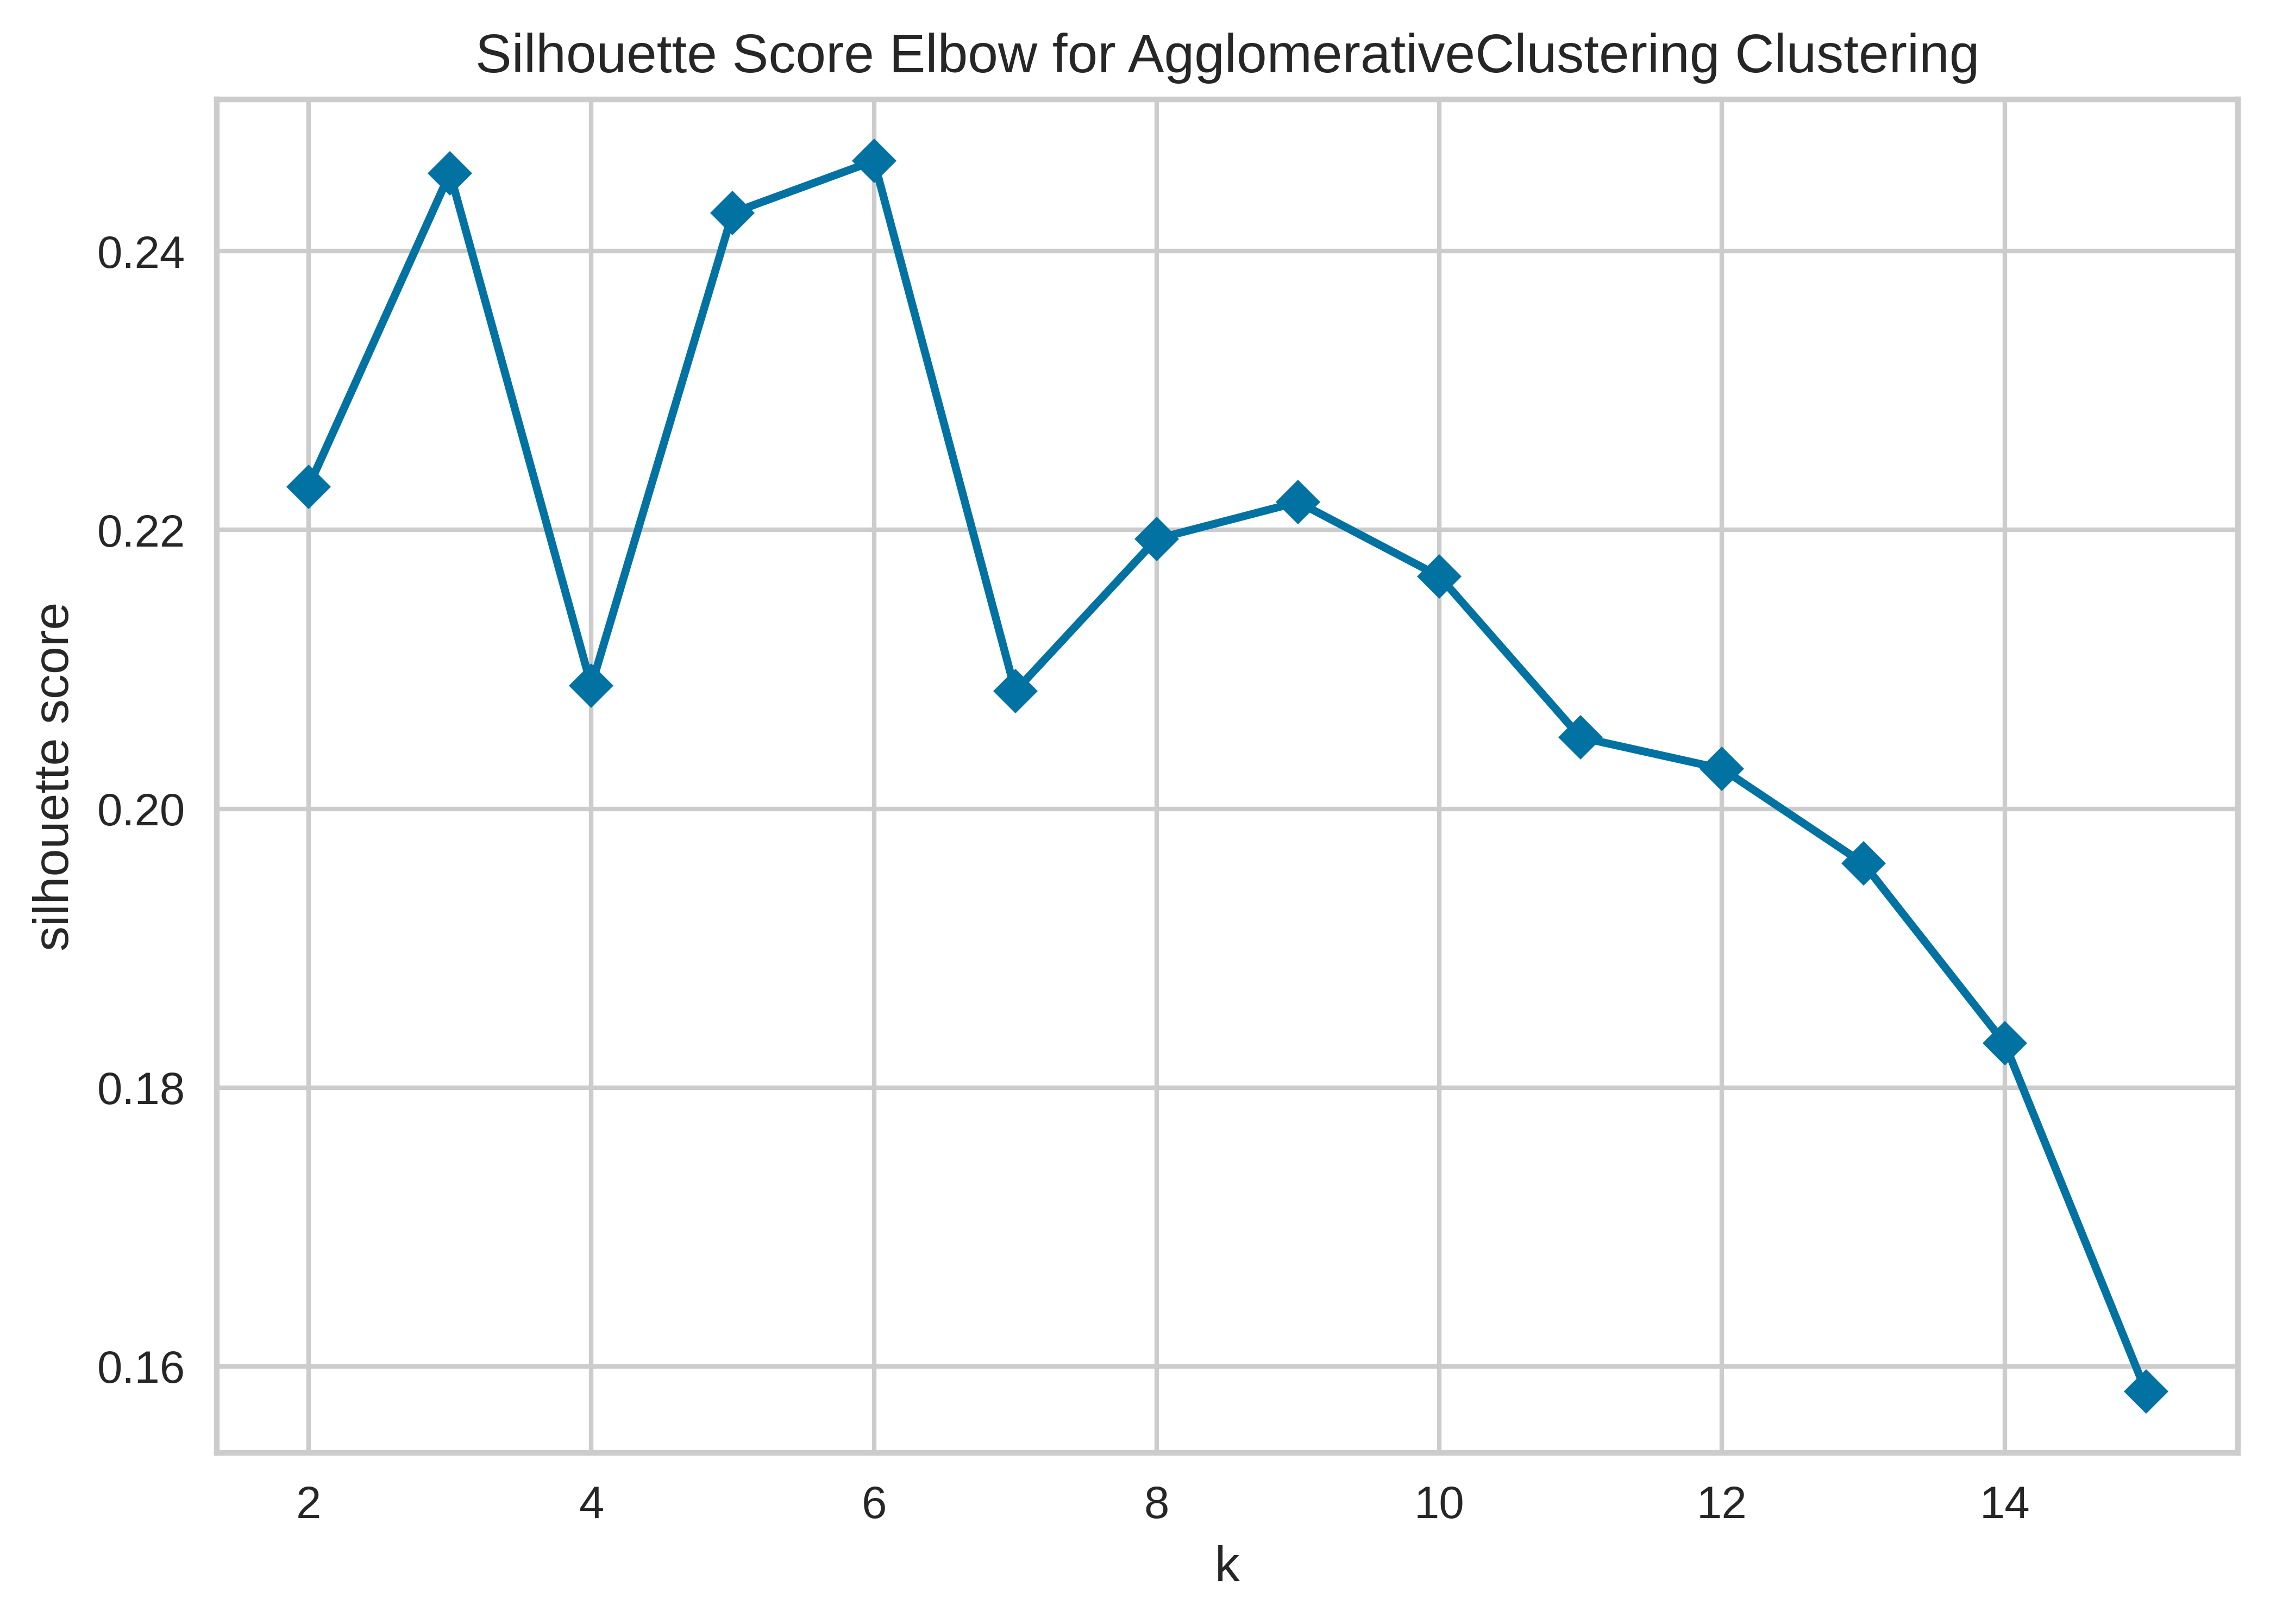

<ipython-input-16-d4ad6d921b49>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_rohban_embs.loc[shared_genes])


<IPython.core.display.Javascript object>

In [16]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_rohban_embs.loc[shared_genes])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_rohban_embs.loc[shared_genes])
ax = visualizer.show()


We observe values close to local optimas around 8 cluster solutions considering both the Silhouette and the Calinski-Harabasz score and thus decide to cluster the Rohban image embeddings for the shared gene targets into 8 clusters.

In [17]:
model = AgglomerativeClustering(n_clusters=8, affinity="euclidean", linkage="complete")
shared_rohban_cluster_labels = model.fit_predict(mean_rohban_embs.loc[shared_genes])
shared_rohban_cluster = pd.DataFrame(
    shared_rohban_cluster_labels,
    index=mean_rohban_embs.loc[shared_genes].index,
    columns=["cluster"],
)

<ipython-input-17-0a9f04bb4e89>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  shared_rohban_cluster_labels = model.fit_predict(mean_rohban_embs.loc[shared_genes])
<ipython-input-17-0a9f04bb4e89>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_rohban_embs.loc[shared_genes].index,


<IPython.core.display.Javascript object>

Using a permutation test we confirm a significant co-clustering of the embeddings from the Rohban et al. 2017 and the JUMP data set as the Mutual Information of the two cluster solutions is significantly higher than expected by chance (p-value=0.037).

In [18]:
jump_rohban_shared_embs_cc_test_results = run_cc_test(
    np.array(shared_jump_cluster.loc[sorted(shared_genes), "cluster"]),
    np.array(shared_rohban_cluster.loc[sorted(shared_genes), "cluster"]),
    random_state=1234,
    score="mi",
    b=100000,
)

100%|██████████| 100000/100000 [00:59<00:00, 1674.02it/s]


<IPython.core.display.Javascript object>

In [19]:
print(
    "MI:",
    jump_rohban_shared_embs_cc_test_results["cc_score"],
    "p-value:",
    jump_rohban_shared_embs_cc_test_results["pval"],
)

MI: 1.0863710778129048 p-value: 0.0365


<IPython.core.display.Javascript object>

The significant co-clustering is also partially visually reflected when overlaying the clustering of the JUMP embeddings to those from Rohban et al. as shown below.

In [20]:
mean_rohban_embs_dist = pd.DataFrame(
    squareform(pdist(mean_rohban_embs.loc[shared_genes])),
    index=mean_rohban_embs.loc[shared_genes].index,
    columns=mean_rohban_embs.loc[shared_genes].index,
)

linkage = hc.linkage(squareform(mean_rohban_embs_dist), method="complete")

ax = sns.clustermap(
    mean_rohban_embs_dist,
    figsize=[14, 12],
    row_linkage=linkage,
    col_linkage=linkage,
    cmap="gray",
    row_colors=np.array(jump_embs_colors.loc[mean_rohban_embs_dist.index]),
    col_colors=np.array(jump_embs_colors.loc[mean_rohban_embs_dist.index]),
    dendrogram_ratio=0.1,
    cbar_pos=(0.04, 0.88, 0.03, 0.1),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
ax.ax_heatmap.set_ylabel("")
ax.ax_heatmap.set_xlabel("")
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

<ipython-input-20-f0f4706a64a3>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  squareform(pdist(mean_rohban_embs.loc[shared_genes])),
<ipython-input-20-f0f4706a64a3>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_rohban_embs.loc[shared_genes].index,
<ipython-input-20-f0f4706a64a3>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  columns=mean_rohban_embs.loc[shared_genes].index,


<IPython.core.display.Javascript object>

While we would expect a greater co-clustering of the two image embeddings there are several changes that had been made to the protocol that are expected to affect the response of the cells in the different overexpression conditions. The most important change is the different use of ORF constructs to overexpress a gene. For Rohban et al. individual alleles were targeted rather than a whole gene and we obtained a joint gene perturbation embedding for each gene by pooling the data from all gene-related allele-overexpression conditions. In contrast, to generate the JUMP data set only one allele was targeted and the used constructs as e.g. for ERG are different. Additionally changes of the cell density might also affect the cellular response to the overexpression as reflected in the chromatin state.

---


### Morphological profiles

Next, we analyze the co-clustering of the morphological profiles from Rohban et al (2017) and the JUMP gene perturbation embeddings.

To this end, we will again for now only consider the 31 perturbation conditions for which data is available for different embedding types.

<ipython-input-21-52173693ab95>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_morph_profiles.loc[shared_genes])


<ipython-input-21-52173693ab95>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_morph_profiles.loc[shared_genes])


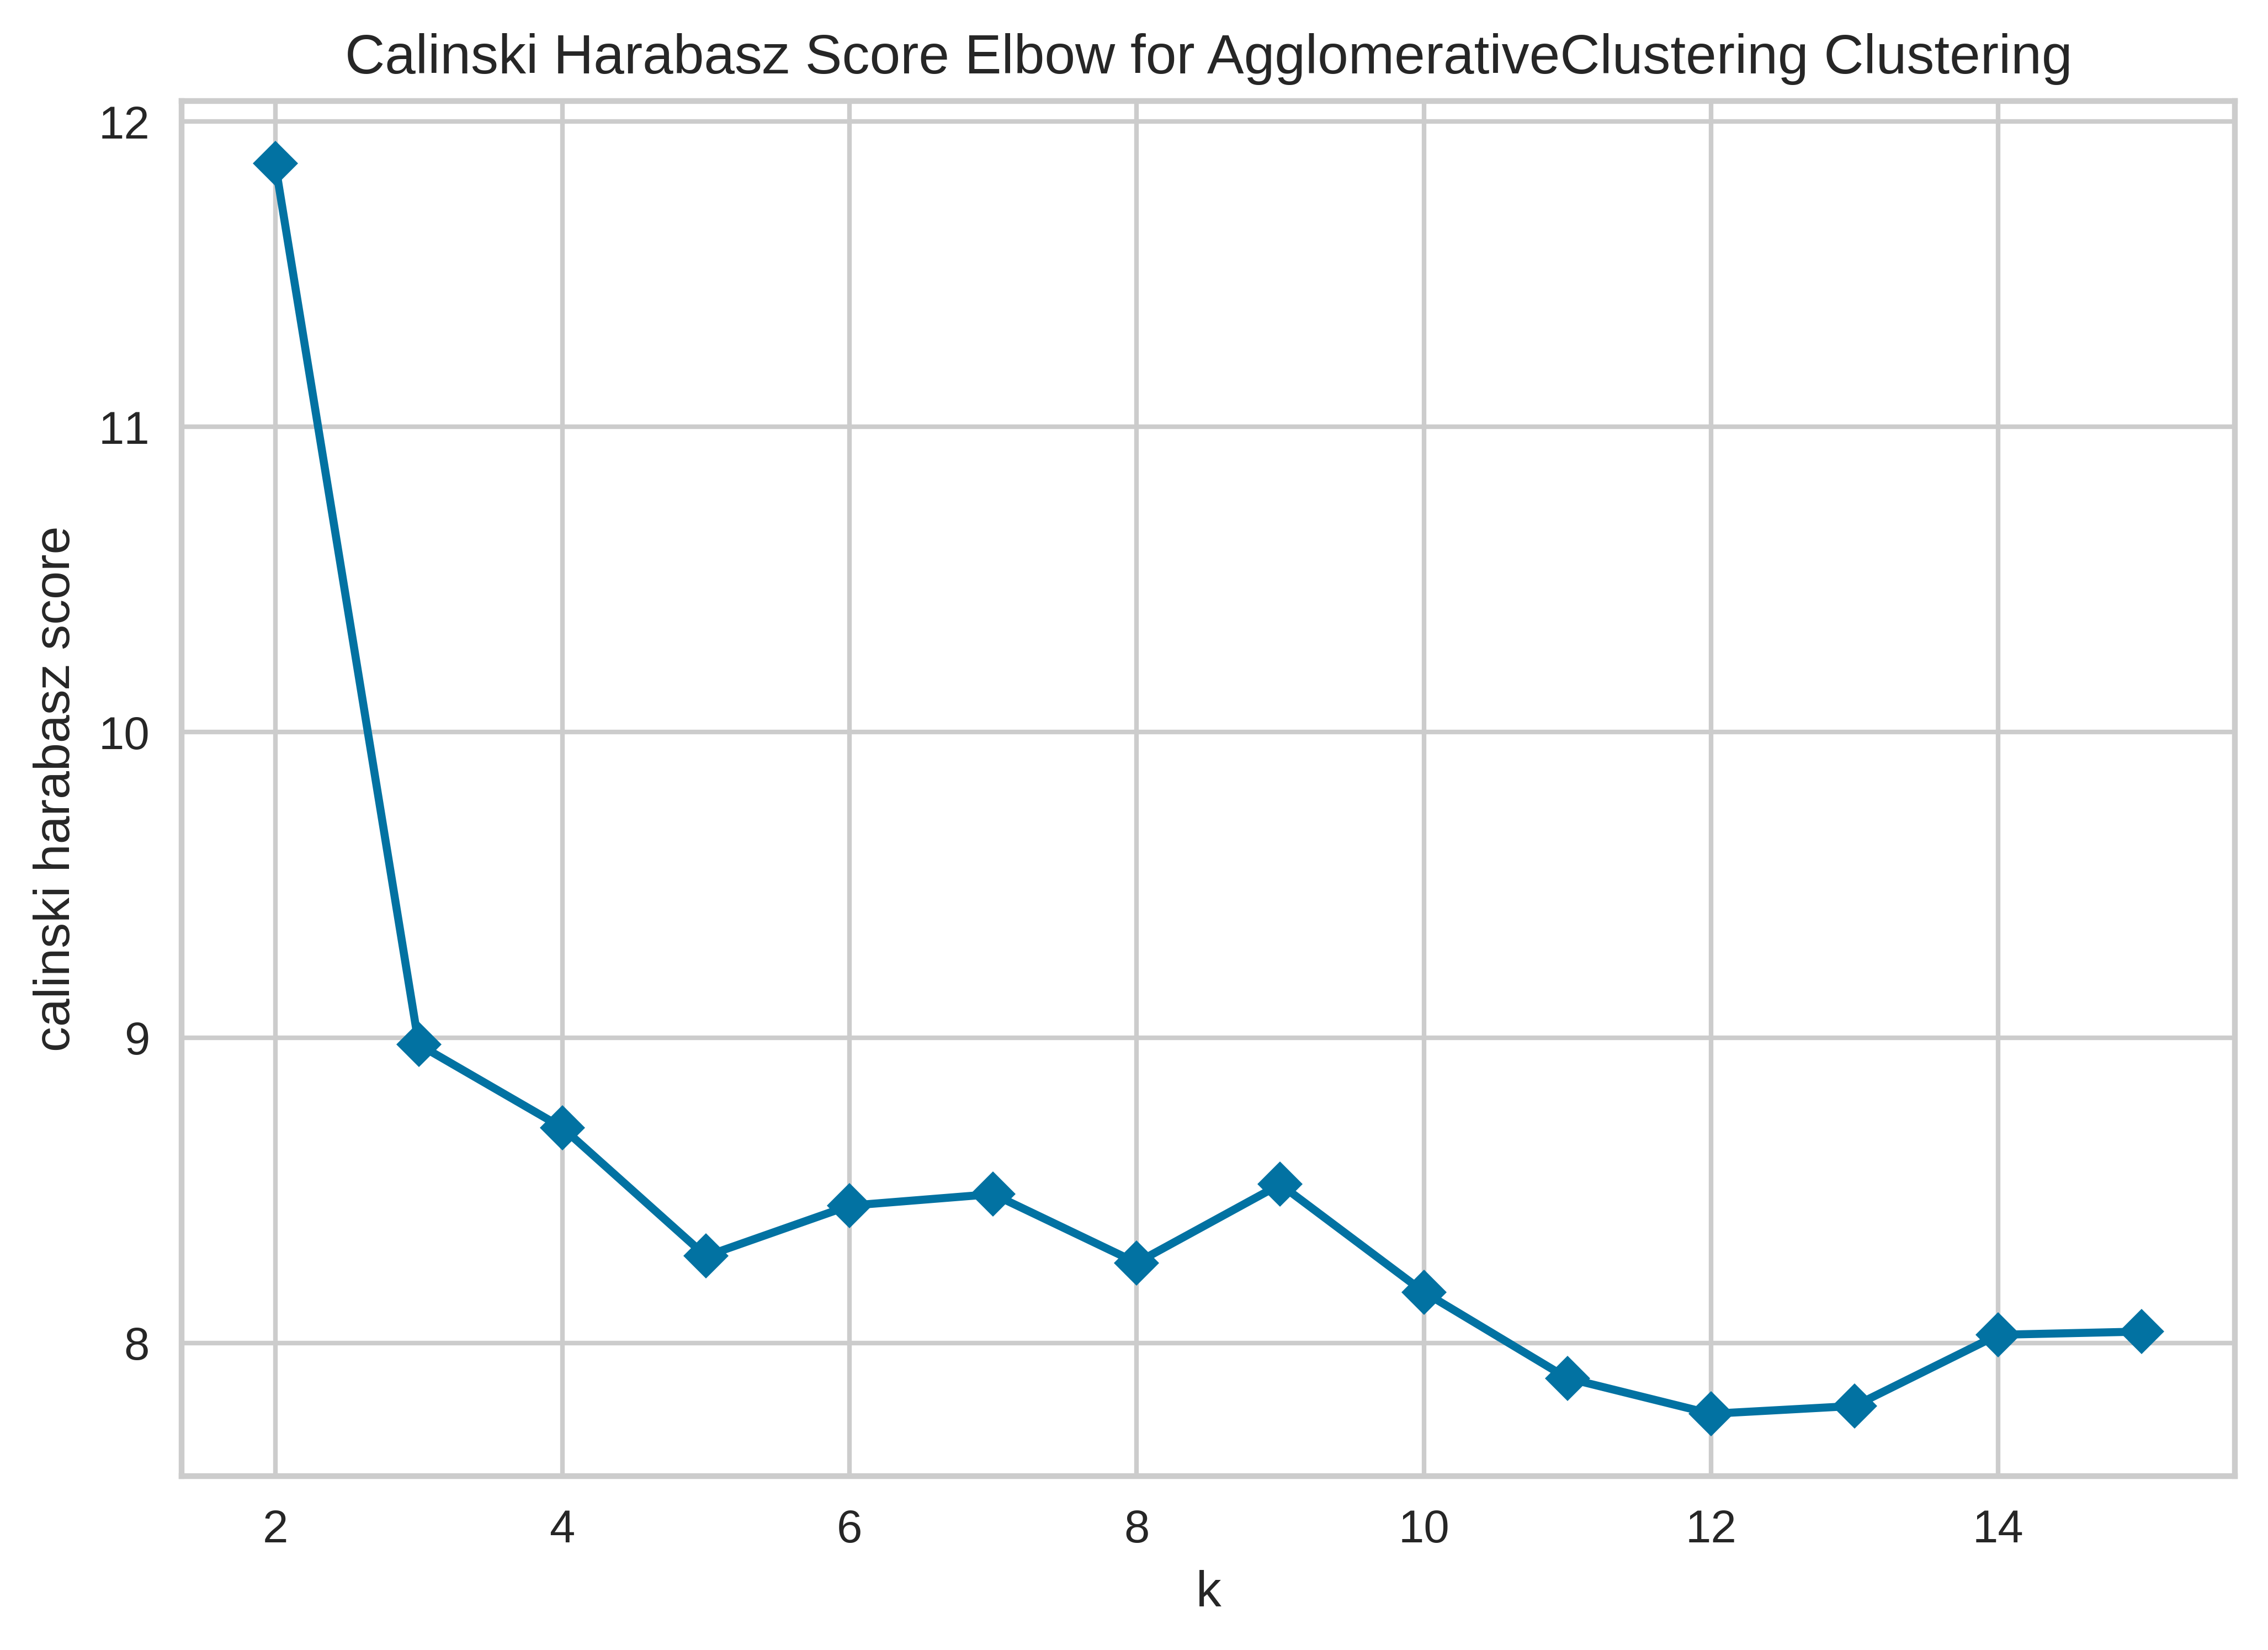

<IPython.core.display.Javascript object>

In [21]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_morph_profiles.loc[shared_genes])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_morph_profiles.loc[shared_genes])
ax = visualizer.show()


The above plots suggest the use of 9 clusters as an optimal choice to group the different perturbation conditions based on the average morphological profiles. We thus do so and visualize the agreement of the clustering with the JUMP image based gene perturbation embeddings by overlaying the respective clusters.

In [22]:
model = AgglomerativeClustering(n_clusters=9, affinity="euclidean", linkage="complete")
shared_profile_cluster_labels = model.fit_predict(mean_morph_profiles.loc[shared_genes])
shared_profile_cluster = pd.DataFrame(
    shared_profile_cluster_labels,
    index=mean_morph_profiles.loc[shared_genes].index,
    columns=["cluster"],
)

<ipython-input-22-8646290f5a57>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  shared_profile_cluster_labels = model.fit_predict(mean_morph_profiles.loc[shared_genes])
<ipython-input-22-8646290f5a57>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_morph_profiles.loc[shared_genes].index,


<IPython.core.display.Javascript object>

In [23]:
mean_profiles_dist = pd.DataFrame(
    squareform(pdist(mean_morph_profiles.loc[shared_genes])),
    index=mean_morph_profiles.loc[shared_genes].index,
    columns=mean_morph_profiles.loc[shared_genes].index,
)

linkage = hc.linkage(squareform(mean_profiles_dist), method="complete")

ax = sns.clustermap(
    mean_rohban_embs_dist,
    figsize=[14, 12],
    row_linkage=linkage,
    col_linkage=linkage,
    cmap="gray",
    row_colors=np.array(jump_embs_colors.loc[mean_profiles_dist.index]),
    col_colors=np.array(jump_embs_colors.loc[mean_profiles_dist.index]),
    dendrogram_ratio=0.1,
    cbar_pos=(0.04, 0.88, 0.03, 0.1),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
ax.ax_heatmap.set_ylabel("")
ax.ax_heatmap.set_xlabel("")
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

<ipython-input-23-b07f73d1d621>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  squareform(pdist(mean_morph_profiles.loc[shared_genes])),
<ipython-input-23-b07f73d1d621>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_morph_profiles.loc[shared_genes].index,
<ipython-input-23-b07f73d1d621>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  columns=mean_morph_profiles.loc[shared_genes].index,


<IPython.core.display.Javascript object>

Visually, we observe no prominent co-clustering structure, which further highlighted by the fact that the mutual information of the two co-cluster solutions is not significantly larger than expected by chance.

In [24]:
jump_profiles_shared_embs_cc_test_results = run_cc_test(
    np.array(shared_jump_cluster.loc[sorted(shared_genes), "cluster"]),
    np.array(shared_profile_cluster.loc[sorted(shared_genes), "cluster"]),
    random_state=1234,
    score="mi",
    b=100000,
)

100%|██████████| 100000/100000 [00:59<00:00, 1682.09it/s]


<IPython.core.display.Javascript object>

In [25]:
print(
    "MI:",
    jump_profiles_shared_embs_cc_test_results["cc_score"],
    "p-value:",
    jump_profiles_shared_embs_cc_test_results["pval"],
)

MI: 0.9473269867162719 p-value: 0.6397


<IPython.core.display.Javascript object>